

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
import PIL    
PIL.__version__
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

In [ ]:
!pip install -U torch torchvision
!pip install -q 'https://download.pytorch.org/whl/torchvision-0.9.1-cp39-cp39-macosx_10_9_x86_64.whl' torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)
ERROR: torchvision-0.9.1-cp39-cp39-macosx_10_9_x86_64.whl is not a supported wheel on this platform.


In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Jun  4 15:24:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook, trange
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
# Нужно поменять размер картинок на 299, иначе будет ошибка, так как размерность станет отрицательной.
# Это вызвано тем, что нейросеть изначально обучалась на картинках размера 299.

# Результирующий размер картинок определяется трансформациями
        if self.mode == 'train': 
            transform = transforms.Compose([
                transforms.RandomResizedCrop(299),
                # transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                # transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255),
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                # transforms.Grayscale(3),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(299),
                transforms.CenterCrop(299),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# TRAIN_DIR = Path('train/dataset')
# TEST_DIR = Path('test/testset')

# train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
# test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

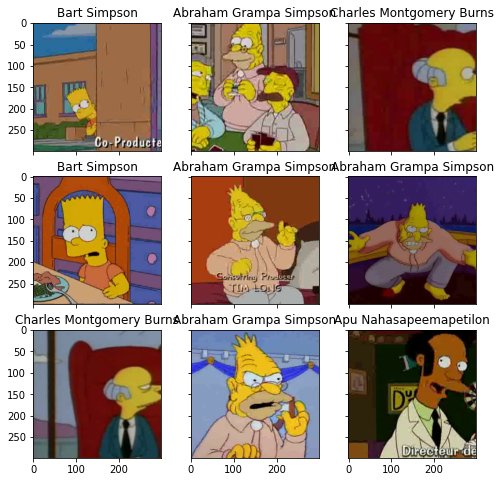

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, opt, criterion, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
use_gpu = torch.cuda.is_available()
from torch.optim import lr_scheduler
import time

In [ ]:
model_extractor = models.inception_v3(pretrained=True)
model_extractor.AuxLogits.fc = nn.Linear(768, n_classes)
model_extractor.fc = nn.Linear(2048, n_classes)

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, n_classes)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = torch.optim.AdamW(model_extractor.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_extractor.aux_logits = False

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=model_extractor, epochs=25, batch_size=4, opt=optimizer, criterion=loss_fn, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:689: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


loss 1.7766933392099047


epoch:   4%|▍         | 1/25 [13:27<5:22:48, 807.00s/it]


Epoch 001 train_loss: 1.7767     val_loss 0.5037 train_acc 0.5522 val_acc 0.8804
loss 3.1065988610708315


epoch:   8%|▊         | 2/25 [26:44<5:08:13, 804.06s/it]


Epoch 002 train_loss: 3.1066     val_loss 2.8664 train_acc 0.1108 val_acc 0.1989
loss 1.8061549518846516


epoch:  12%|█▏        | 3/25 [39:58<4:53:41, 800.99s/it]


Epoch 003 train_loss: 1.8062     val_loss 0.5360 train_acc 0.5100 val_acc 0.8619
loss 1.0448882565270103


epoch:  16%|█▌        | 4/25 [53:04<4:38:47, 796.54s/it]


Epoch 004 train_loss: 1.0449     val_loss 0.4476 train_acc 0.7264 val_acc 0.8909
loss 0.9212872548849188


epoch:  20%|██        | 5/25 [1:06:08<4:24:18, 792.93s/it]


Epoch 005 train_loss: 0.9213     val_loss 0.4773 train_acc 0.7578 val_acc 0.8770
loss 0.8232519420057968


epoch:  24%|██▍       | 6/25 [1:19:10<4:10:03, 789.65s/it]


Epoch 006 train_loss: 0.8233     val_loss 0.3374 train_acc 0.7839 val_acc 0.9159
loss 0.7856215988621373


epoch:  28%|██▊       | 7/25 [1:32:11<3:56:07, 787.07s/it]


Epoch 007 train_loss: 0.7856     val_loss 0.2261 train_acc 0.7938 val_acc 0.9467
loss 0.5836280476520347


epoch:  32%|███▏      | 8/25 [1:45:17<3:42:54, 786.75s/it]


Epoch 008 train_loss: 0.5836     val_loss 0.1469 train_acc 0.8466 val_acc 0.9681
loss 0.535971731765485


epoch:  36%|███▌      | 9/25 [1:58:20<3:29:31, 785.70s/it]


Epoch 009 train_loss: 0.5360     val_loss 0.1381 train_acc 0.8556 val_acc 0.9729
loss 0.5100796123693226


epoch:  40%|████      | 10/25 [2:11:30<3:16:40, 786.72s/it]


Epoch 010 train_loss: 0.5101     val_loss 0.1288 train_acc 0.8672 val_acc 0.9746
loss 0.48715039466226473


epoch:  44%|████▍     | 11/25 [2:24:35<3:03:26, 786.21s/it]


Epoch 011 train_loss: 0.4872     val_loss 0.1221 train_acc 0.8724 val_acc 0.9755
loss 0.47849000901841193


epoch:  48%|████▊     | 12/25 [2:37:39<2:50:15, 785.80s/it]


Epoch 012 train_loss: 0.4785     val_loss 0.1184 train_acc 0.8760 val_acc 0.9757
loss 0.47129892184351163


epoch:  52%|█████▏    | 13/25 [2:50:43<2:37:02, 785.17s/it]


Epoch 013 train_loss: 0.4713     val_loss 0.1174 train_acc 0.8769 val_acc 0.9759
loss 0.47564090989843527


epoch:  56%|█████▌    | 14/25 [3:03:53<2:24:11, 786.53s/it]


Epoch 014 train_loss: 0.4756     val_loss 0.1165 train_acc 0.8734 val_acc 0.9738
loss 0.45130577419060586


epoch:  60%|██████    | 15/25 [3:17:05<2:11:23, 788.31s/it]


Epoch 015 train_loss: 0.4513     val_loss 0.1095 train_acc 0.8795 val_acc 0.9776
loss 0.4565771505956138


epoch:  64%|██████▍   | 16/25 [3:30:13<1:58:13, 788.13s/it]


Epoch 016 train_loss: 0.4566     val_loss 0.1084 train_acc 0.8787 val_acc 0.9786
loss 0.44447047721793365


epoch:  68%|██████▊   | 17/25 [3:43:20<1:45:02, 787.76s/it]


Epoch 017 train_loss: 0.4445     val_loss 0.1061 train_acc 0.8832 val_acc 0.9797
loss 0.42113915801828244


epoch:  72%|███████▏  | 18/25 [3:56:22<1:31:43, 786.18s/it]


Epoch 018 train_loss: 0.4211     val_loss 0.1052 train_acc 0.8885 val_acc 0.9801
loss 0.4314678165713363


epoch:  76%|███████▌  | 19/25 [4:09:24<1:18:28, 784.80s/it]


Epoch 019 train_loss: 0.4315     val_loss 0.1052 train_acc 0.8842 val_acc 0.9796
loss 0.4279228902538237


epoch:  80%|████████  | 20/25 [4:22:25<1:05:18, 783.72s/it]


Epoch 020 train_loss: 0.4279     val_loss 0.1045 train_acc 0.8863 val_acc 0.9797
loss 0.4264018259062023


epoch:  84%|████████▍ | 21/25 [4:35:26<52:11, 782.98s/it]


Epoch 021 train_loss: 0.4264     val_loss 0.1048 train_acc 0.8875 val_acc 0.9803
loss 0.42003534347052224


epoch:  88%|████████▊ | 22/25 [4:48:25<39:05, 781.80s/it]


Epoch 022 train_loss: 0.4200     val_loss 0.1046 train_acc 0.8901 val_acc 0.9801
loss 0.4268503295632666


epoch:  92%|█████████▏| 23/25 [5:01:26<26:02, 781.41s/it]


Epoch 023 train_loss: 0.4269     val_loss 0.1047 train_acc 0.8853 val_acc 0.9801
loss 0.4269581536759861


epoch:  96%|█████████▌| 24/25 [5:14:41<13:05, 785.39s/it]


Epoch 024 train_loss: 0.4270     val_loss 0.1045 train_acc 0.8838 val_acc 0.9799
loss 0.4386796101002218


epoch: 100%|██████████| 25/25 [5:27:48<00:00, 786.74s/it]


Epoch 025 train_loss: 0.4387     val_loss 0.1046 train_acc 0.8821 val_acc 0.9799


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

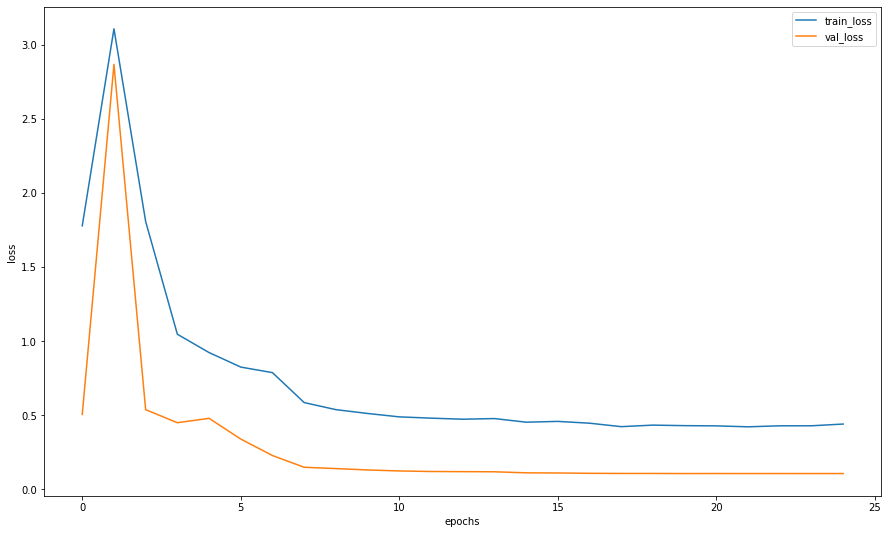

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_extractor, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

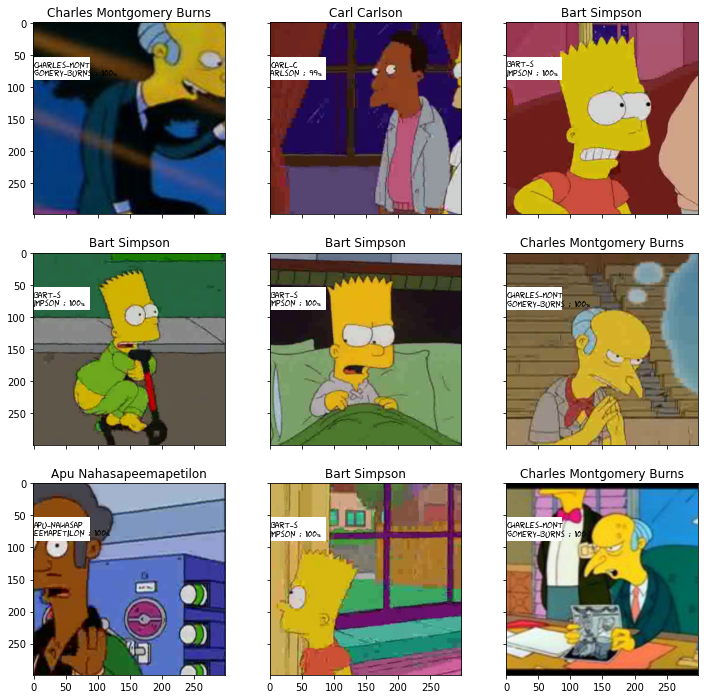

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_extractor, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/Stepik/Deep Learning 2001 (семестр 1, весна 2021): продвинутый поток/5/simple_cnn_baseline_inception_v3.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
